In [1]:
from dataset import *
import torch
print(torch.__version__)
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
from PIL import Image
from modules import *
from save_history import *

1.5.1


Load Claudio data

In [3]:
from os.path import join
from czifile import CziFile
with CziFile(join("../../test2.czi")) as czi:
    
    image_arrays = czi.asarray()
    meta = czi.metadata(raw=False)

Create PNG images

In [4]:
import matplotlib.pyplot as plt

for x in range (0, 60):
    img = image_arrays[0, 0, 0, x, 0, :, :, 0]
    plt.imsave(join("Claudio_png", "test", str(x)+".png"), img, cmap='gray_r') #guarda en escala de grises invertido

Load model

In [5]:
model = torch.load('../model_epoch_100.pwf', map_location=torch.device('cpu')).module.cpu()
model.eval()

/home/phuijse/.conda/envs/organogenesis/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.parallel.data_parallel.DataParallel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/phuijse/.conda/envs/organogenesis/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/phuijse/.conda/envs/organogenesis/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has ch

CleanU_Net(
  (Conv_down1): Conv_down(
    (conv): Double_conv(
      (conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Conv_down2): Conv_down(
    (conv): Double_conv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Conv_down3): Conv_down(
    (conv): Double_conv(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))


## Torch dataset para las imágenes de Claudio

Luis:

Quiero que entiendas perfectamente lo que está pasando en el siguiente bloque, lee la documentación de torchvision
- El dataset lo creo con ImageFolder. Las imágenes deben estar en "Claudio_png/test"
- Le aplico transforms para llevarlo a escala de grises e imitar el crop/padding que se usaba nates
- Finalmente le aplico una transformación custom para "corregir la imagen"

> El objetivo es que las imágenes de Claudio se vean más parecidas a las del challenge

Por ejemplo subir el contraste mejora bastante la detección pero aun no es perfecto. Revisa tu que otras transformaciones funcionales podrían servir https://pytorch.org/docs/stable/torchvision/transforms.html

También podría servir usar las funciones que dejé en el notebook classic en particular denoise_image

<IPython.core.display.Javascript object>


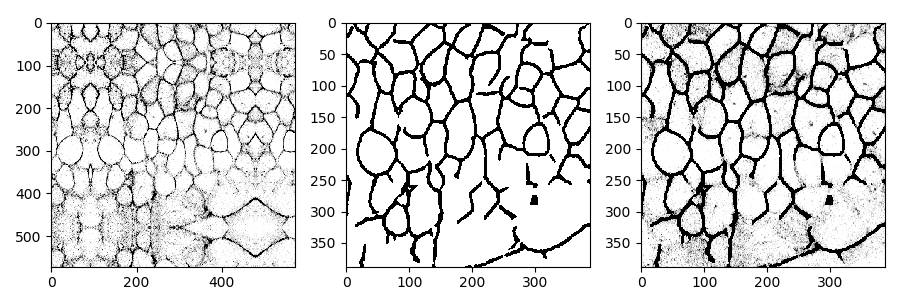

In [8]:
import torchvision
import torchvision.transforms.functional as TF

# https://pytorch.org/docs/stable/torchvision/transforms.html

class ImproveImageTransform:
    
    def __init__(self, contrast_factor=1, brightness_factor=1):
        self.contrast_factor = contrast_factor
        self.brightness_factor = brightness_factor

    def __call__(self, x):
        #x = TF.adjust_gamma(x, gamma=1)
        x = TF.adjust_brightness(x, self.brightness_factor)
        x = TF.adjust_contrast(x, self.contrast_factor)
        return x
    

my_transforms = torchvision.transforms.Compose([torchvision.transforms.Grayscale(),
                                                torchvision.transforms.CenterCrop(388),
                                                #torchvision.transforms.FiveCrop(388),
                                                torchvision.transforms.Pad(padding=(572-388)//2,
                                                                           padding_mode='reflect'),
                                                ImproveImageTransform(contrast_factor=3),
                                                torchvision.transforms.ToTensor()])
claudio_dataset = torchvision.datasets.ImageFolder("Claudio_png", transform=my_transforms)


claudio_loader = torch.utils.data.DataLoader(dataset=claudio_dataset, batch_size=1, 
                                             num_workers=2, shuffle=False)

for image, label in claudio_loader:
    with torch.no_grad():
        output = model.forward(image)
        output = torch.argmax(output, dim=1).float()
    break
    
%matplotlib notebook
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(9, 3), tight_layout=True)
pad = (572-388)//2
ax[0].imshow(image.numpy()[0, 0], cmap=plt.cm.Greys_r)
ax[1].imshow(output.numpy()[0], cmap=plt.cm.Greys_r)

borders_on_top = image.numpy()[0, 0, pad:-pad, pad:-pad].copy()
idx = np.where(output.numpy()[0].astype(int) == 0)
borders_on_top[idx[0], idx[1]] = 0
ax[2].imshow(borders_on_top, cmap=plt.cm.Greys_r)

Alternative, adapt orignal code:

In [ ]:
class ClaudioDataTest(Dataset):

    def __init__(self, image_path, in_size=572, out_size=388):
        '''
        Args:
            image_path = path where test images are located
            mask_path = path where test masks are located
        '''
        # paths to all images and masks

        self.image_arr = glob.glob(str(image_path) + str("/*"))
        self.in_size = in_size
        self.out_size = out_size
        self.data_len = len(self.image_arr)

    def __getitem__(self, index):
        '''Get specific data corresponding to the index
        Args:
            index: an integer variable that calls(indext)th image in the
                path
        Returns:
            Tensor: 4 cropped data on index which is converted to Tensor
        '''

        single_image = self.image_arr[index]
        img_as_img = Image.open(single_image)
        # img_as_img.show()
        # Convert the image into numpy array
        # OJO: ACA LA IMAGEN SE CORTA Y SE BOTAN LOS CANALES
        img_as_np = np.asarray(img_as_img)[:self.in_size, :self.in_size, 0]
        pad_size = int((self.in_size - self.out_size)/2)
        img_as_np = np.pad(img_as_np, pad_size, mode="symmetric")
        img_as_np = multi_cropping(img_as_np,
                                   crop_size=self.in_size,
                                   crop_num1=2, crop_num2=2)

        # Empty list that will be filled in with arrays converted to tensor
        processed_list = []

        for array in img_as_np:

            # SANITY CHECK: SEE THE PADDED AND CROPPED IMAGES
            # array_image = Image.fromarray(array)

            # Normalize the cropped arrays
            img_to_add = normalization2(array, max=1, min=0)
            # Convert normalized array into tensor
            processed_list.append(img_to_add)

        img_as_tensor = torch.Tensor(processed_list)
        #  return tensor of 4 cropped images
        #  top left, top right, bottom left, bottom right respectively.
        return img_as_tensor

    def __len__(self):

        return self.data_len
    
claudio_dataset = ClaudioDataTest("Claudio_png/test")
claudio_loader = torch.utils.data.DataLoader(dataset=claudio_dataset, batch_size=1, 
                                             num_workers=2, shuffle=False)

for images_t in claudio_loader:
    stacked_img = torch.Tensor([])
    
    for index in range(images_t.size()[1]):
        print(index)
        with torch.no_grad():
            image_t = Variable(images_t[:, index, :, :].unsqueeze(0))            
            # print(image_v.shape, mask_v.shape)
            output_t = model.forward(image_t)
            output_t = torch.argmax(output_t, dim=1).float()
            stacked_img = torch.cat((stacked_img, output_t))
        break
    break


In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].imshow(image_t.numpy()[0, 0], cmap=plt.cm.Greys_r)
ax[1].imshow(output_t.numpy()[0], cmap=plt.cm.Greys_r)